# Tutorial for `MDRefine` - 1

Refinement of the structural ensembles and forward models

In these notebooks we are going to perform several different refinements of MD-generated trajectories by employing the package `MDRefine`. In this way, we believe the usage of `MDRefine` will become clear and easy to emulate for your own case of interest.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [ ]:
# install matplotlib and other dependencies
!pip install -r requirements.txt

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# import from parent directory
import sys
sys.path.insert(0, '../')

import MDRefine

print("I will use the MDRefine version installed at", MDRefine.__file__)

I will use the MDRefine version installed at ../MDRefine/__init__.py


In [3]:
from MDRefine import load_data, minimizer, split_dataset, hyper_minimizer, MDRefinement, unwrap_dict


## 1. Ensemble refinement

In this section, we are going to reproduce results from *T. Fröhlking et al., "Simultaneous refinement of molecular dynamics ensembles and forward models using experimental data", J. Chem. Phys. 158, 214120 (2023)* https://pubs.aip.org/aip/jcp/article/158/21/214120/2894410.

They regard the refinement of the structural ensembles of RNA oligomers (Ensemble Refinement based on the max. entropy principle), with possible flexibility on the forward models (Karplus equations).

In [4]:
%%bash

if [ ! -d "DATA" ]; then
    echo "download DATA from Zenodo"
    curl -O https://zenodo.org/records/14956459/files/DATA.zip

    unzip DATA.zip
    rm -r DATA.zip
fi

### a. Load data

In order to perform the refinement, we first need to store the data from MD simulations and experiments in a directory structured as described in https://arxiv.org/pdf/2411.07798 - *Structure of `data` objects*. Then, we can define the `infos` dictionary, which informs about which input files are going to be read, and run the `load_data` function.

The output of `load_data` is a class instance `data` with all the quantities required in the following steps (see again Section *Structure of `data` objects*).

- 1. Just load the observables (without force-field terms nor forward quantities)

In [5]:
infos = {}

# Firstly, define global properties, valid for all the systems:

infos['global'] = {}

# 'name of the folder with data'
infos['global']['path_directory'] = 'DATA'

# system names
system_names = ['AAAA', 'CAAU']  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC']
infos['global']['system_names'] = system_names

# Then, define properties which are specific of each system, like experimental data and observables

for name in system_names:
    infos[name] = {}
    
    # experimental observables (average and uncertainty), corresponding to 'file_name'.npy in DATA/system_name/g_exp/
    # uNOEs values are upper bounds, so specify '<' with ('uNOEs','<')
    infos[name]['g_exp'] = ['NOEs', ('uNOEs','<')]
    
    # observables from MD simulations, corresponding to 'file_name'.npy in DATA/system_name/observables/
    # they must correspond also to items of infos[name]['g_exp']
    infos[name]['obs'] = ['NOEs', 'uNOEs']

# If some properties are the same for all the systems, you can store them just once in infos['global']

infos['global']['temperature'] = 1 # namely, energies are in unit of k_B T (default value)
# (in this case, you could do this also for 'g_exp' and 'obs')

# Select the stride for the frames (thinner strides will require more time for minimizations; default value = 1)
stride = 10

- 2. Include also quantities computed through the defined forward model

In [6]:
for name in system_names:
    # include experimental values also for 3J scalar couplings
    infos[name]['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs','<')]

    # include quantities required to compute observables through the forward model
    # they must correspond to 'file_name'.npy in DATA/system_name/forward_qs/
    infos[name]['forward_qs'] = ['backbone1_gamma','backbone2_beta_epsilon','sugar']

# starting values of the forward model coefficients: specify the file name inside DATA/
infos['global']['forward_coeffs'] = 'original_fm_coeffs' # string

Now, let's define the **forward model**.

In our case-study, the forward model is given by the **Karplus equations**:

$^3 J_\gamma = A_\gamma \, cos^2\gamma \, + \, B_\gamma \, cos\gamma \, + \, C_\gamma$

with empirical coefficients $A_\gamma,\,B_\gamma,\,C_\gamma$ ($\gamma$ dihedral angles), and analogously for $^3 J_{\beta/\epsilon}$ (same coefficients both for $\beta$ and $\epsilon$ dihedral angles) and $^3J_\nu$ (sugar dihedral angles).

**WARNING**: `forward_model_fun` returns a dict `forward_qs_out` whose keys must correspond to those of the associated experimental values `g_exp`, as specified in `infos`.

In [7]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = np.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8]}

    return forward_qs_out

In [8]:
# same forward-model function for each system, so store it in infos['global']
infos['global']['forward_model'] = forward_model_fun

In [9]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
done


### b. Minimize the loss function and analyse the results
for a single choice of the hyper-parameter $\alpha$

Namely, let's perform ensemble refinement with a given value of the hyperparameter $\alpha$, representing the strength to the original ensembles generated from the MD simulations.

In [10]:
# use function minimizer with selected data and alpha as input
Result = minimizer(data, alpha=1)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

`minimizer` returns a class instance `Result`, let's have a look at it

In [11]:
print(vars(Result).keys())

dict_keys(['loss', 'min_lambdas', 'minis', 'time', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])


In [12]:
# check the convergence
for name_sys in data.properties.system_names:
    print(Result.minis[name_sys].success, Result.minis[name_sys].message)

# min. value of the loss function
print('optimal loss: ', Result.loss)
print('time required: ', Result.time)

# Kullback-Leibler divergence
print('D_KL: ', Result.D_KL_alpha)

True b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
True b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
optimal loss:  22.041717740436116
time required:  11.839823246002197
D_KL:  {'AAAA': DeviceArray(2.89315516, dtype=float64), 'CAAU': DeviceArray(2.94417582, dtype=float64)}


- then, let's look at the optimal ensembles $P^*$ **weights_new** (completely defined by the starting ensembles and by the **min_lambdas** coefficients), together with their (log) normalization factor **logZ_new**. Let's plot them.

system AAAA:
effective n. of frames (on the total n.):  0.0554011371259131
logZ:  -48.8379587456847
system CAAU:
effective n. of frames (on the total n.):  0.052645431093149835
logZ:  -25.624464834913276


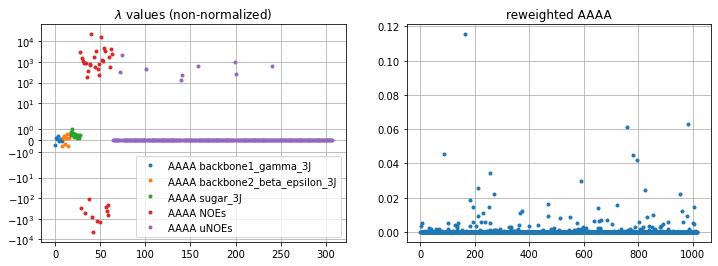

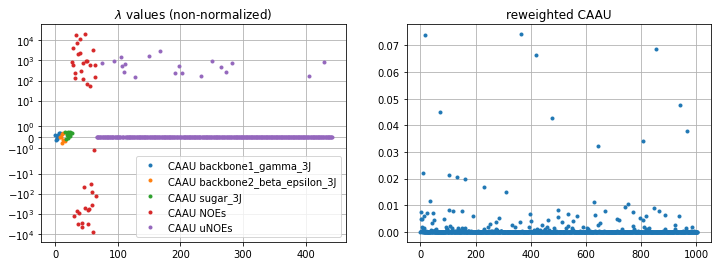

In [13]:
for s in system_names:

    plt.figure(figsize = (12,4))

    plt.subplot(1,2,1)

    l = 0
    for i2,s2 in enumerate(Result.min_lambdas[s].keys()):
        l_new = l+len(Result.min_lambdas[s][s2])
        plt.plot(np.arange(l,l_new),Result.min_lambdas[s][s2],'.',label='%s %s' % (s,s2))
        l = l_new

    plt.title('$\lambda$ values (non-normalized)')
    plt.legend()# loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.yscale('symlog')

    plt.subplot(1,2,2)
    
    plt.plot(Result.weights_new[s],'.')
    plt.title('reweighted %s' % s)
    plt.grid()
    
    n_eff = np.exp(-Result.D_KL_alpha[s])

    print('system %s:' % s)
    print('effective n. of frames (on the total n.): ', n_eff)
    print('logZ: ', Result.logZ_new[s])


- finally, let's look at the average values of the observables in the new ensembles **av_g** and associated **chi2**; compare with experimental values gexp and with average values of the original ensembles.

chi2:  7.546078526391822
observables (first names in list):
 [["A1-H1'" 'A1-H8']
 ["A1-H1'" 'A2-H8']
 ['A1-H2' "A2-H1'"]
 ["A1-1H2'" 'A1-H8']
 ["A1-1H2'" "A2-H1'"]]


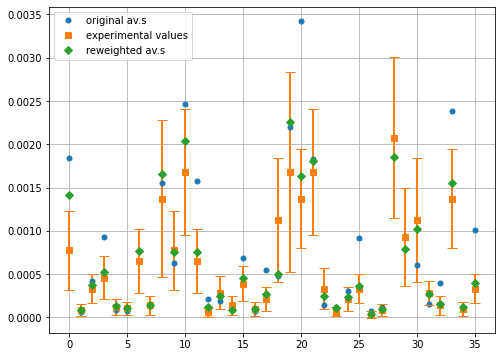

In [14]:
s1 = 'AAAA'
s2 = 'NOEs'

print('chi2: ',Result.chi2[s1][s2])
print('observables (first names in list):\n',data.mol[s1].names[s2][:5])

plt.figure(figsize=(8,6))

# compute average values with original ensemble
g_mean = np.matmul(data.mol[s1].weights, data.mol[s1].g[s2])

plt.plot(g_mean,'.',label='original av.s',markersize=10)

plt.plot(data.mol[s1].gexp[s2][:,0],'s',label='experimental values')
plt.errorbar(np.arange(len(data.mol[s1].gexp[s2][:,0])), data.mol[s1].gexp[s2][:,0], data.mol[s1].gexp[s2][:,1], fmt = ' ',
    color = 'tab:orange', capsize = 5, lw = 2)

plt.plot(Result.av_g[s1][s2], 'D', label = 'reweighted av.s')

plt.legend()
plt.grid()

### c. Determine optimal hyper parameter $\alpha$ through cross validation (scan over $\alpha$)

The hyperparameter $\alpha$ tunes the reliability given to the original ensemble in spite of the trust to experimental data.

Suitable values of $\alpha$ can be determined through a **cross validation procedure**: randomly split the full data set into training and validation set, then select the value of $\alpha$ which minimizes the $\chi^2$ on the validation set (either same observables as in training but new frames or new observables); repeat over several splittings.

For the moment, let's perform just one splitting into training/validation set (as an example) and scan over different values of $\alpha$ (in logarithmic scale).

The function **split_dataset** can be used to get **data_train** and **data_valid** by simply passing a **random_state** (a random integer), which randomly selects **valid_obs** and **valid_frames**.

In [15]:
# split into data_cv (for cross validation) and data_test

data_cv, data_test, test_obs, test_frames = split_dataset(data, frames_fraction=0)
# data_train, data_valid, valid_obs, valid_frames = split_dataset(data_train_and_valid, random_state=1)

split observables only (not frames)
random state:  613
Input random_state employed for valid_obs only


In [16]:
data_train, data_valid, valid_obs, valid_frames = split_dataset(data_cv, random_state=1)

Input random_state employed both for valid_obs and valid_frames


In [17]:
data_train, data_valid, valid_obs, valid_frames = split_dataset(data, random_state=1)

Input random_state employed both for valid_obs and valid_frames


In [18]:
print(data.properties.tot_n_experiments(data))
print(data_test.properties.tot_n_experiments(data_test))
print(data_cv.properties.tot_n_experiments(data_cv))

print(data_valid.properties.tot_n_experiments(data_valid))
print(data_train.properties.tot_n_experiments(data_train))

751
151
600
600
600


In [19]:
s = 'NOEs'

print(data.mol['AAAA'].g[s].shape)
print(data_train.mol['AAAA'].g[s].shape)
print(data_valid.mol['AAAA'].g[s].shape)
print(data_valid.mol['AAAA'].g_new[s].shape)

print(data_cv.mol['AAAA'].g[s].shape)
print(data_test.mol['AAAA'].g[s].shape)

(1017, 36)
(814, 30)
(203, 30)
(203, 6)
(1017, 31)
(1017, 5)


In [20]:
n_tot_exp = data.properties.tot_n_experiments(data)
n_valid_exp = len(unwrap_dict(valid_obs))

n_train_exp = n_tot_exp - n_valid_exp

print('tot. n. of observables: ', n_tot_exp)
print('n. of validation observables: ', n_valid_exp)
print('n. of training observables', n_train_exp)

tot. n. of observables:  751
n. of validation observables:  151
n. of training observables 600


Default values for the fraction of validation observables and frames are $20\%$ for both (you can change this ratio by selecting **valid_frames_size** and/or **valid_obs_size** as input variables). By default, validation observables are evaluated only on validation frames; you can also consider both on training and validation frames, by setting **if_all_frames** = True.

In [21]:
# You can also select different values from the default ones
data_train, data_valid, valid_obs, valid_frames = split_dataset(data, frames_fraction=0.2, obs_fraction=0.3,
    random_state=4, if_all_frames=True)

Input random_state employed both for valid_obs and valid_frames


In [22]:
# Alternatively, you can also directly pass valid_obs and valid_frames.
out = split_dataset(data, valid_obs=valid_obs, valid_frames=valid_frames)

data_train = out[0]
data_valid = out[1]

Input random_state will not be used


In any case, you can now scan over different values of $\alpha$ for a given partition of the full data set into training and validation set. Let's work directly with logarithms in base 10, in order to explore several orders of magnitude for $\alpha$.

Let's pass `data_valid` as input to `minimizer`: after the minimization of the loss function on `data_train`, relevant properties (such as $D_{KL}$, $\chi^2$, loss function) are evaluated on the validation frames and a further $\chi^2$ is evaluated on validation observables.

In [23]:
log10_alphas = np.arange(-2, 7, 1)

Results = {}

for log10_alpha in log10_alphas:
    print(log10_alpha)

    alpha = 10**np.float64(log10_alpha)
    Results[log10_alpha] = minimizer(data_train, alpha=alpha, data_valid=data_valid)

    clear_output()

In [24]:
vars(Results[log10_alpha]).keys()

dict_keys(['loss', 'min_lambdas', 'minis', 'time', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new', 'loss_valid', 'D_KL_alpha_valid', 'abs_difference_valid', 'av_g_valid', 'chi2_valid', 'logZ_new_valid', 'weights_new_valid', 'avg_new_obs', 'chi2_new_obs'])

For each value of the hyperparameter $\alpha$, we now have corresponding quantities for validation frames (such as **loss_valid**, **D_KL_alpha_valid**, **av_g_valid**, **chi2_valid**, **weights_new_valid**) and for validation observables (**avg_new_obs** and **chi2_new_obs**).

Let's compare the loss function for training set and validation set (new frames):
- at high values of $\alpha$, the two values almost overlap;
- decreasing $\alpha$, both the two loss functions decrease, except that the one on the validation at a certain point starts to increase marking overfitting.

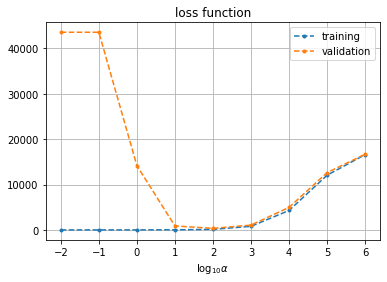

In [25]:
loss = [Results[log10_alpha].loss for log10_alpha in log10_alphas]
loss_valid = [Results[log10_alpha].loss_valid for log10_alpha in log10_alphas]

plt.title('loss function')
plt.plot(log10_alphas, loss, '.--', label = 'training')
plt.plot(log10_alphas, loss_valid, '.--', label = 'validation')
plt.xlabel(r'$\log_{10}\alpha$')
plt.legend()
plt.grid()

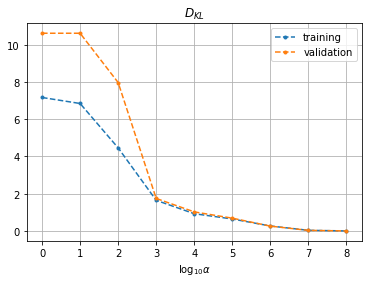

In [26]:
D_KL_train = [np.sum(unwrap_dict(Results[log10_alpha].D_KL_alpha)) for log10_alpha in log10_alphas]
D_KL_valid = [np.sum(unwrap_dict(Results[log10_alpha].D_KL_alpha_valid)) for log10_alpha in log10_alphas]

plt.title('$D_{KL}$')
plt.plot(D_KL_train, '.--', label = 'training')
plt.plot(D_KL_valid, '.--', label = 'validation')
plt.xlabel(r'$\log_{10}\alpha$')
plt.legend()
plt.grid()

Now, the $\chi^2$, including also validation observables

In [27]:
chi2s = [np.sum(unwrap_dict(Results[log10_alpha].chi2)) for log10_alpha in log10_alphas]
n_obs_train = data_train.properties.tot_n_experiments(data_train)

red_chi2s = np.array(chi2s)/n_obs_train

chi2s_valid1 = [np.sum(unwrap_dict(Results[log10_alpha].chi2_valid)) for log10_alpha in log10_alphas]  # .chi2_valid
red_chi2s_valid1 = np.array(chi2s_valid1)/n_obs_train

chi2s_valid2 = [np.sum(unwrap_dict(Results[log10_alpha].chi2_new_obs)) for log10_alpha in log10_alphas]  # .chi2_valid
n_obs_valid = len(unwrap_dict(valid_obs))

red_chi2s_valid2 = np.array(chi2s_valid2)/n_obs_valid

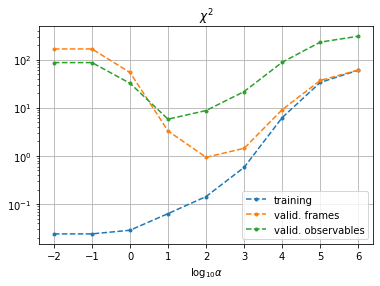

In [28]:
plt.plot(log10_alphas, red_chi2s, '.--', label = 'training')
plt.plot(log10_alphas, red_chi2s_valid1, '.--', label = 'valid. frames')
plt.plot(log10_alphas, red_chi2s_valid2, '.--', label = 'valid. observables')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\alpha$')
plt.yscale('log')
plt.grid()

### d. Determine optimal hyper parameter $\alpha$ through cross validation (automatic optimization)

Rather than performing a scan over the hyperparameter $\alpha$, we now minimize the $\chi^2$ on the validation set (computed at optimal parameters obtained in training) with respect to $\alpha$.

In [29]:
starting_alpha = 10**5

By default, it is `which_set = 'valid_frames'` (rather than `'validation'` or `'training'`), namely the cross validation is performed on the $\chi^2$ evaluated on the same observables as training but left-out frames of the trajectory (you can also select `which_set = 'validation'`, which means, $\chi^2$ on left-out observables).

In [30]:
mini = hyper_minimizer(data, starting_alpha=starting_alpha, random_states=2, which_set='valid_frames', gtol=0.5)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

In [31]:
mini

          fun: DeviceArray(728.9507908, dtype=float64)
     hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.hyperminimizer.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7f94b4275e10>
          jac: array([5.69082552])
      message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
         nfev: 9
          nit: 8
         njev: 9
       status: 0
      success: True
            x: array([2.14009329])

In [32]:
optimal_alpha = 10**(mini.x)

print(optimal_alpha)

[138.06808223]


This optimal value of the hyperparameter is compatible with that reported in the previous plot. We can now minimize the loss function at this optimal value.

In [33]:
Result = minimizer(data, alpha=optimal_alpha)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

### e. Do all together with `MDRefinement`

All these steps are consequentially performed by `MDRefinement`, which first loads the stored data, then determine the optimal hyperparameters through automatic minimization of validation $\chi^2$ and finally minimize the loss function at optimized value of the hyperparameter.

In [34]:
Result = MDRefinement(data_cv, stride=stride, starting_alpha=1e5, random_states=2, which_set='validation', gtol=0.5)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

In [35]:
vars(Result)

{'loss': DeviceArray(200.36222494, dtype=float64),
 'min_lambdas': {'AAAA': {'backbone1_gamma_3J': DeviceArray([-0.00511928,  0.00095846,  0.00332249,  0.00023635,
                 0.00109534, -0.00042617], dtype=float64),
   'backbone2_beta_epsilon_3J': DeviceArray([-0.00664073,  0.00464869, -0.00663767,  0.00252055,
                 0.00495067, -0.00856623, -0.00060791,  0.00642053],            dtype=float64),
   'sugar_3J': DeviceArray([0.00650644, 0.00440507, 0.00794992, 0.00466447, 0.00487543,
                0.00289648, 0.00192181, 0.00443837, 0.00142657],            dtype=float64),
   'NOEs': DeviceArray([ 40.69060578, -15.57410927,  45.82343438,  37.30946801,
                -23.95332484,  14.94470186,   0.40127226,  11.95659729,
                 32.64658143, 296.97697852, -13.86641859, -28.3746417 ,
                 53.0759489 ,  -6.46939689, 111.05878814,   3.08925931,
                 34.94210913,   0.47905243, -26.1835347 , 153.84131494,
                 39.23376429,  97.10

Here, you can look at the values contained in `Result` as previously done in Section b.